In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\User\Desktop\El final\AIML\my repo\Assignments\assignment_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#check if cuda available
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch is using {dev}")

Torch is using cuda


In [3]:
#load dataset
#small so dont need to stream
dataset = load_dataset("dair-ai/emotion")

In [4]:
print(dataset["train"][0])
print("Sample labels from dataset:", dataset["train"]["label"][:10])

{'text': 'i didnt feel humiliated', 'label': 0}
Sample labels from dataset: [0, 0, 3, 2, 3, 0, 5, 4, 1, 2]


In [5]:
#setup tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased") #use bert as tokenizer base
MAX_LEN = 50 #50 token length as max

#setup tokenizer function
def tokenize(batch) -> AutoTokenizer:
    return tokenizer(batch["text"], padding='max_length', truncation=True, max_length=MAX_LEN)

In [8]:
dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map: 100%|██████████| 2000/2000 [00:00<00:00, 8557.63 examples/s]


In [9]:
#format dataset function
def format_dataset(split) -> dict: 
    return {
        'input_ids': torch.tensor(split["input_ids"], dtype=torch.long),
        'attention_mask': torch.tensor(split["attention_mask"], dtype=torch.long),
        'labels': torch.tensor(split["label"], dtype=torch.long)
    }

In [10]:
#format dataset
dataset = {key: format_dataset(dataset[key]) for key in dataset.keys()}

In [12]:
NUM_CLASSES = 6

In [13]:
#dataset class
class EmotionDataset(Dataset):
    def __init__(self, data, device):
        self.input_ids = data['input_ids'].to(device)
        self.attention_mask = data['attention_mask'].to(device)
        self.labels = data['labels'].to(device)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
train_data = EmotionDataset(dataset["train"], dev)
val_data = EmotionDataset(dataset["validation"], dev)
test_data = EmotionDataset(dataset["test"], dev)

In [15]:
#data laoder
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [20]:
#CNN class
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Update convolution layers' input channels to match the first Conv1D output
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=4, padding=1)  # Input now matches Conv1 output
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=1)  # Input now matches Conv1 output
        
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, input_ids):
        x = self.embedding(input_ids).permute(0, 2, 1)  # (batch_size, embed_dim=100, seq_length=50)
        x = F.relu(self.conv1(x))  # Output shape: (batch_size, 128, seq_length)
        x = F.relu(self.conv2(x))  # Now correctly receives 128 input channels
        x = F.relu(self.conv3(x))  # Now correctly receives 128 input channels
        x = self.pool(x)
        x = torch.mean(x, dim=2)  # Global average pooling
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [21]:
#model setup
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 100

model = CNNTextClassifier(VOCAB_SIZE, EMBED_DIM, NUM_CLASSES).to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
#train model function
EPOCHS = 10
def train_model():
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(EPOCHS):
        epoch_loss = 0
        correct, total = 0, 0
        for input_ids, _, labels in train_loader:
            input_ids, labels = input_ids.to(dev), labels.to(dev)
            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_acc = correct / total
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}")
train_model()

Epoch 1, Train Loss: 1.5396, Train Acc: 0.3337
Epoch 2, Train Loss: 1.0882, Train Acc: 0.5224
Epoch 3, Train Loss: 0.6967, Train Acc: 0.7160
Epoch 4, Train Loss: 0.5145, Train Acc: 0.7981
Epoch 5, Train Loss: 0.3824, Train Acc: 0.8614
Epoch 6, Train Loss: 0.2606, Train Acc: 0.9094
Epoch 7, Train Loss: 0.1674, Train Acc: 0.9428
Epoch 8, Train Loss: 0.1237, Train Acc: 0.9553
Epoch 9, Train Loss: 0.1018, Train Acc: 0.9653
Epoch 10, Train Loss: 0.0763, Train Acc: 0.9739


              precision    recall  f1-score   support

           0       0.90      0.93      0.91       581
           1       0.93      0.89      0.91       695
           2       0.72      0.66      0.69       159
           3       0.81      0.89      0.85       275
           4       0.87      0.91      0.89       224
           5       0.75      0.64      0.69        66

    accuracy                           0.88      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.88      0.88      0.88      2000



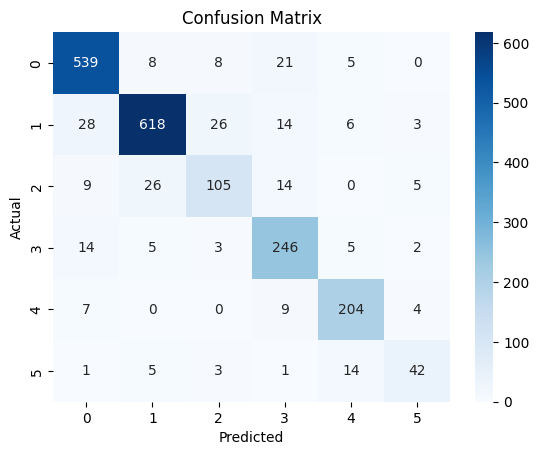

In [23]:
#Evaluate model
def evaluate():
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for input_ids, _, labels in test_loader:
            input_ids, labels = input_ids.to(dev), labels.to(dev)
            outputs = model(input_ids)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
evaluate()